In [1]:
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels
import csv
import pickle

# Processing Data from PostGRES Output

Creating a single JSON file for each participant from PostGRES data that contains a single list of all participant data

In [290]:
fileprefix = "full_r_5.1" # pilot_[1,2,4]
datafolder = '../results/'
filepath = '{}/{}_results.json'.format(datafolder,fileprefix)


In [291]:
with open(filepath, 'r') as f:
    all_data = json.load(f)

In [295]:
part_data = {}

count = 0
for participant in all_data['values']:
    count+=1
    print(count, participant[2])
    try:
        part_object = json.loads(participant[17])
        # Update condition here by setting part_object["condition"]
        # print(part_object["condition"])
        part_object["condition"] = 0
        part_object["Beginhit"] = participant[11]
        part_object["Beginexp"] = participant[12]
        part_object["Endhit"] = participant[13]
        part_object["psiturkStatus"] = participant[15]
        part_object["browser"] = participant[5]
        part_object["platform"] = participant[6]
        part_object["language"] = participant[7]
        
        if part_object["workerId"].startswith("debug"):
            continue

        part_data[part_object["workerId"]] = part_object
        with open('../results/{}_{}.json'.format(fileprefix, part_object['workerId']), 'w') as fw:
            json.dump(part_object, fw)
    except:
        print("Fail")
        continue;

1 debugcxwI1
2 debugB0mPe
3 5f0f59f3bc44f50f92845a05
4 63d13d1465e0743b7b2b7962
5 60643e9b1b2e851ff9238862


In [296]:
part_data.keys()


dict_keys(['5f0f59f3bc44f50f92845a05', '63d13d1465e0743b7b2b7962', '60643e9b1b2e851ff9238862'])

In [297]:
len(part_data.keys())

3

# Reading Data from Already Created Participant Data Files

In [48]:
fileprefix = "full_r" # pilot_#, final
datafolder = '../results/'

all_part_files = [filename for filename in os.listdir(datafolder) if filename.startswith(fileprefix) and 'results' not in filename]
all_part_paths = [datafolder + filename for filename in all_part_files]

In [49]:
part_data = {}
for file in all_part_paths:
    with open(file, 'r') as f:
        participant = json.load(f)
        part_data[participant["workerId"]] = participant



In [50]:
len(part_data.keys())

437

In [51]:
print(",\n".join(part_data.keys()))

613789190e10970db0b4399f,
596e1edd39e9d00001b7bb98,
614395b646280ec3c4ab1d49,
6159f5208087ddd970d727d1,
60cce1dff5946c42b4402084,
5f5547c3a0ac76108f69e767,
6137753896c9b6b5813a2432,
60f815535ea713f564c6ed61,
5b587d897846fa0001fc11c6,
60da0dd4c8268e2d7125907e,
616ed458582d2c3b50149493,
5e8c13d8f743d210d47ec874,
5e72087440aeca126bf6326c,
60dceeaa19d94b7d2651c389,
61190367632a534f9e11b013,
60f6b8f8e574e14634ead43e,
5d0fe250ddf9e30015012fb8,
5f97f80e8279d602b5dfd6b1,
5f9aeb04901ce62720fc6838,
5c50efd2cc71f4000125ce0d,
614209228e118f9a8a39922a,
6365805113952480bdeed7b7,
615fdd9674ec001e9d325841,
6155841573df9e7e0d71a709,
58f669cefb4d7500014af69b,
60dc380c84658bee9d398f7b,
610eff018bca56cf0d30624b,
60f946e5de3e8cd2bb450e8d,
616d8b61fc7348856d538881,
5adbd63ae0feeb0001ca9865,
60cd99f1d0df72833ad4346a,
6346e10721ce6a0ebc5a5907,
60e5ae1dabf4db8c1de4c2c4,
60f38f94b789eee75b769c34,
5964ee31b752840001ca4ba4,
61635ae3040c7eba5e61449f,
612bef062e4e035e081ba009,
6113d1d02fbd58ed15b3c8e0,
6164091188e0

# Analyzing Trial Data

Create a list of objects, one for each participant's data

In [52]:
# List of participants who are excluded and the reason for exclusion

excluded_parts = []

In [53]:
part_stats_dicts = []
extract_max_trials = 40
for participant in part_data.values():
    try:
        beginhit = datetime.datetime.strptime(participant['Beginhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginhit = None
    try:
        endhit = datetime.datetime.strptime(participant['Endhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        endhit = None
    try:    
        beginexp = datetime.datetime.strptime(participant['Beginexp'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginexp = None
    
    try:
        hitLength = (endhit-beginhit).seconds
    except TypeError:
        hitLength = None
    
    try:
        expLength = (endhit-beginexp).seconds
    except TypeError:
        expLength = None
        
    numPracTrials = 0
    trialLengths = []
    trialScores = []
    rewardsWithheld = []
    reached_max_trials = False
    effort = "-1"
    age = None
    gender = None
    colorblind = None
    print(participant['workerId'])
    try:
        firstTrialStamp = participant['data'][0]['dateTime']
        lastTrialStamp = participant['data'][-1]['dateTime']
    except Exception as e:
        print("No data")
        continue
    if hitLength is None:
        hitLength = (lastTrialStamp - firstTrialStamp) / 1000
    expLength = (lastTrialStamp - firstTrialStamp) / 1000
        
    mdp_timestamps = {
        "start" : 0,
        "end" : 0,
        "done": False
    }
    current_state = "stroop_1"
    last_trial = participant['data'][0]
    finishHITReached = False
    demographicsAvailable = False
    feedback = ""
    alreadyParticipated = ""
    comments = ""
    whatStrategy = ""
    clicksL1 = []
    firstLevelAns = {}
    clickStratsValid = True
    strategyImprove = ""
    difficult = ""
    num_correct_sequences = 0
    final_quiz_responses = None
    for idx, trial in enumerate(participant['data']):
        trial_type = trial['trialdata']['trial_type']
        try:
            trial_id = str(trial['trialdata']['trial_id'])
        except KeyError:
            trial_id = ""
        
        if participant['workerId'] == "5eb40f1f0d916d20d9db9144":
            print("{}\t{}\t{}".format(trial_type, trial_id, idx))
            
        if trial_id.startswith("mouselab_instructions_1") and not mdp_timestamps["done"]:
            mdp_timestamps["done"] = True
            mdp_timestamps["start"] = trial['dateTime']
        
        if "num_correct_sequences" in trial['trialdata']:
            num_correct_sequences = trial['trialdata']['num_correct_sequences']
        
        if trial_id.startswith("final_quiz"):
            mdp_timestamps["end"] = trial['dateTime']
            final_quiz_responses = trial['trialdata']['response']

        if trial_id.startswith("self_report_2"):
            firstLevelAns = trial['trialdata']['response']
        
        if trial_id.startswith("finish_fail"):
            feedback = trial['trialdata']['response']['Q0']
            age = trial['trialdata']['response']['Q1']
            gender = trial['trialdata']['response']['Q2']
            colorblind = trial['trialdata']['response']['Q3']
            comments = trial['trialdata']['response']['Q4']
            demographicsAvailable = True
            
        if trial_type == 'mouselab-mdp':
            if trial_id.startswith('practice'):
                numPracTrials += 1
            else:
                if extract_max_trials and len(trialScores) == extract_max_trials:
                    if not reached_max_trials:
                        reached_max_trials = True
                        print(f"!!! More than {extract_max_trials} trials found !!!")
                trialLengths.append(trial['trialdata']['trialTime'])
                
                trialScores.append(trial['trialdata']['score'])
                rewardsWithheld.append(trial['trialdata']['withholdReward'])
                clicks = trial['trialdata']['queries']['click']['state']['target']
                cL1 = len([c for c in clicks if int(c) in [1,12,23]])
                clicksL1.append(cL1)
        if trial_type == 'survey-html-form':
            
            if 'effort' in trial['trialdata']['response']:
                effort = int(trial['trialdata']['response']['effort'])
                age = trial['trialdata']['response']['age']
                gender = trial['trialdata']['response']['gender']
                colorblind = trial['trialdata']['response']['colorblind']
                demographicsAvailable = True
        
        elif trial_type == 'survey-text':
            if trial_id.startswith("self_report"):
                whatStrategy = trial['trialdata']['response']['Q0']
                strategyImprove = trial['trialdata']['response']['Q1']
                difficult = trial['trialdata']['response']['Q2']
            
            elif not trial_id.startswith("answer"):
                #print(trial['trialdata'])
                feedback = trial['trialdata']['response']['Q0']
                alreadyParticipated = trial['trialdata']['response']['Q1']
                comments = trial['trialdata']['response']['Q2']
        
        if trial_type == 'html-button-response':
            if "Finish HIT" in trial['trialdata']['stimulus']:
                finishHITReached = True
        last_trial = trial
    
    # Checking if click strategies are invalid
    if firstLevelAns:
        # Criteria 1: clicks made on first level nodes on more than 10% of the trials
        madeL1Clicks = sum([bool(c) for c in clicksL1])/len(clicksL1) >= 0.10
        # Criteria 2: did not pay attention to the values at the first level - average agreement with
        #   negative statements greater than 2 (indifference)
        
        # Assessed by answers to Q5 and Q6
        possible_answers = ["Strongly disagree", "Disagree", "Neither disagree nor agree", "Agree", "Strongly agree"]
        
        # "... I did pay attention"
        scoreQ5 = possible_answers.index(firstLevelAns["Q5"])
        # "... I did NOT pay attention"
        scoreQ6 = possible_answers.index(firstLevelAns["Q6"])
        adj_scoreQ6 = len(possible_answers) - scoreQ6 - 1
        
        avg_attn_score = (scoreQ5 + adj_scoreQ6) / 2
        clickStratsValid = not madeL1Clicks or (avg_attn_score >= 2)
    dropoutPoint = None
    for obj, type_ in zip([mdp_timestamps], ["mdp"]):
        if obj["start"] > 0 and obj["end"] == 0:
            
            dropoutPoint = type_
            obj["end"] = lastTrialStamp
            
    if not dropoutPoint:
        if len(trialLengths) == 0:
            dropoutPoint = "beginning"
        elif not finishHITReached:
            dropoutPoint = "finishHIT"
            
    if dropoutPoint:
        print(participant['workerId'], dropoutPoint)
    part_stats_dict = {
        "workerId": participant['workerId'],
        "Beginhit": beginhit,
        "Endhit": endhit,
        "Beginexp": beginexp,
        "psiturkStatus" : participant["psiturkStatus"],
        "browser" : participant["browser"],
        "platform" : participant["platform"],
        "language" : participant["language"],
        "hitLength": hitLength,
        "expLength": expLength,
        "totalLengthSum": (lastTrialStamp - firstTrialStamp) / 1000,
        "numQuizAttempts": numPracTrials / 2,
        "trialLengths": trialLengths,
        "trialScores" : trialScores,
        "numTrialsCompleted": len(trialLengths),
        "rewardsWithheld": rewardsWithheld,
        "effort": effort,
        "clicksL1": clicksL1,
        "age":age,
        "colorblind":colorblind,
        "gender":gender,
        "condition": participant['condition'],
        "mouselabLength" : (mdp_timestamps["end"] - mdp_timestamps["start"]) / 1000,
        "dropoutPoint" : dropoutPoint,
        "feedback": feedback,
        "alreadyParticipated": alreadyParticipated,
        "comments": comments,
        "finishHITReached": finishHITReached,
        "demographicsAvailable": demographicsAvailable,
        "whatStrategy": whatStrategy,
        "strategyImprove": strategyImprove,
        "difficult": difficult,
        "firstLevelAns": firstLevelAns,
        "num_correct_sequences": num_correct_sequences,
        "final_quiz_responses": final_quiz_responses,
        "clickStratsValid": clickStratsValid
    }
    if 'questiondata' in participant and 'final_score' in participant['questiondata']:
        part_stats_dict['finalScore'] = participant['questiondata']['final_score']
    else:
        part_stats_dict['finalScore'] = sum([score for (score, withheld) in zip(trialScores, rewardsWithheld) if not withheld])
    
    part_stats_dict["expLengthSum"] = part_stats_dict["mouselabLength"]
    part_stats_dict["expLengthDiff"] = part_stats_dict["expLengthSum"] - part_stats_dict["expLength"]
    if len(trialLengths) > 0:
        part_stats_dict["averageTrialLength"] = sum(trialLengths) / len(trialLengths)
        part_stats_dict["propWithheld"] = sum(rewardsWithheld) / len(rewardsWithheld)
        
    part_stats_dicts.append(part_stats_dict)
    

613789190e10970db0b4399f
596e1edd39e9d00001b7bb98
596e1edd39e9d00001b7bb98 finishHIT
614395b646280ec3c4ab1d49
614395b646280ec3c4ab1d49 mdp
6159f5208087ddd970d727d1
6159f5208087ddd970d727d1 mdp
60cce1dff5946c42b4402084
60cce1dff5946c42b4402084 mdp
5f5547c3a0ac76108f69e767
5f5547c3a0ac76108f69e767 finishHIT
6137753896c9b6b5813a2432
60f815535ea713f564c6ed61
5b587d897846fa0001fc11c6
5b587d897846fa0001fc11c6 beginning
60da0dd4c8268e2d7125907e
616ed458582d2c3b50149493
5e8c13d8f743d210d47ec874
5e72087440aeca126bf6326c
60dceeaa19d94b7d2651c389
61190367632a534f9e11b013
60f6b8f8e574e14634ead43e
5d0fe250ddf9e30015012fb8
5d0fe250ddf9e30015012fb8 finishHIT
5f97f80e8279d602b5dfd6b1
5f97f80e8279d602b5dfd6b1 finishHIT
5f9aeb04901ce62720fc6838
5c50efd2cc71f4000125ce0d
614209228e118f9a8a39922a
614209228e118f9a8a39922a finishHIT
6365805113952480bdeed7b7
6365805113952480bdeed7b7 finishHIT
615fdd9674ec001e9d325841
6155841573df9e7e0d71a709
6155841573df9e7e0d71a709 mdp
58f669cefb4d7500014af69b
58f669cefb4d75

In [54]:
stats_df = pd.DataFrame(part_stats_dicts)
print(len(stats_df))
filter_cols = ["workerId", "Beginhit", "hitLength", "expLength", "condition", "numQuizAttempts", "numTrialsCompleted", "mouselabLength", "finalScore", "num_correct_sequences", "dropoutPoint", "finishHITReached", "psiturkStatus", "effort", "demographicsAvailable"]
stats_df[filter_cols]

432


,workerId,Beginhit,hitLength,expLength,condition,numQuizAttempts,numTrialsCompleted,mouselabLength,finalScore,num_correct_sequences,dropoutPoint,finishHITReached,psiturkStatus,effort,demographicsAvailable
0,613789190e10970db0b4399f,2023-09-01 10:34:41.245987,2293.00,2266.097,1,1.0,40,1291.962,556.9,0,None,True,3,0,True
1,596e1edd39e9d00001b7bb98,2023-09-02 13:11:42.111633,1391.00,1385.727,1,1.0,40,927.627,1498.5,0,finishHIT,False,3,0,True
2,614395b646280ec3c4ab1d49,2023-08-31 11:40:58.212238,1127.00,1066.054,1,4.0,0,1026.097,0.0,0,mdp,True,3,-1,True
3,6159f5208087ddd970d727d1,2023-09-01 14:56:31.787421,1204.00,1182.296,1,4.0,0,896.829,0.0,0,mdp,False,3,-1,True
4,60cce1dff5946c42b4402084,2023-09-01 11:13:02.134156,154.42,154.420,0,0.0,0,0.000,0.0,0,mdp,False,6,-1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,60867f15c6327e78242c627c,2023-09-01 10:40:56.556944,1978.00,1967.683,1,1.0,40,1401.213,1830.2,0,None,True,3,0,True
428,61601e9a6b8306196d2a129c,2023-08-31 11:27:40.207915,1548.00,1534.507,0,1.0,40,893.898,1848.4,0,None,True,3,0,True
429,60e00818b935a41dcfb1cccd,2023-08-31 11:43:11.852818,545.00,525.477,0,1.0,0,394.394,0.0,0,mdp,True,3,-1,False
430,5873b2d22bd3c90001859b76,2023-09-04 13:38:17.899850,3549.00,3458.335,1,2.0,40,2606.157,2194.1,0,finishHIT,False,3,0,True


In [55]:
# Filter those who dropped out immediately

immediate_drops = stats_df.loc[(stats_df.dropoutPoint == "beginning")]
print(len(immediate_drops))
immediate_drops

11


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
8,5b587d897846fa0001fc11c6,2023-09-01 11:38:14.587798,NaT,2023-09-01 11:39:44.292568,6,chrome,windows,en-US,8.267,8.267,...,,{},0,None,True,0.0,0.0,-8.267,NaN,NaN
50,614dd477b69221b863e025af,2023-08-31 11:30:29.015372,NaT,2023-08-31 11:30:42.322420,6,chrome,windows,en-US,21.541,21.541,...,,{},0,None,True,0.0,0.0,-21.541,NaN,NaN
124,5e3421311ddb123e1de9e6ad,2023-08-31 11:49:14.993009,NaT,2023-08-31 11:49:19.921062,6,chrome,windows,en-US,0.000,0.000,...,,{},0,None,True,0.0,0.0,0.000,NaN,NaN
182,615ec038e5541708b1925af2,2023-08-30 09:52:20.745119,NaT,2023-08-30 09:53:18.170167,2,chrome,windows,en-US,71.025,71.025,...,,{},0,None,True,0.0,0.0,-71.025,NaN,NaN
208,60cc72425533320442c05f8c,2023-08-31 11:25:49.761065,NaT,2023-08-31 11:26:01.472389,6,chrome,macos,en-US,47.004,47.004,...,,{},0,None,True,0.0,0.0,-47.004,NaN,NaN
254,6176b584db27cdcecc3896c8,2023-08-30 10:50:35.865442,NaT,2023-08-30 10:50:52.571723,6,chrome,windows,en-GB,15.073,15.073,...,,{},0,None,True,0.0,0.0,-15.073,NaN,NaN
280,613110abdaced6861846c409,2023-08-30 09:49:06.654850,NaT,2023-08-30 09:49:27.548290,6,chrome,windows,en-US,24.198,24.198,...,,{},0,None,True,0.0,0.0,-24.198,NaN,NaN
321,5c8cfc3772503f0001e9c965,2023-09-02 13:11:26.232570,NaT,2023-09-02 13:14:24.049703,6,chrome,windows,en-US,6.606,6.606,...,,{},0,None,True,0.0,0.0,-6.606,NaN,NaN
325,60daf06339dsacaccef1a00932,2023-09-04 13:33:46.632311,NaT,2023-09-04 13:33:50.755253,6,chrome,macos,en-US,0.596,0.596,...,,{},0,None,True,0.0,0.0,-0.596,NaN,NaN
340,5fad0a601ab00734f83bf339,2023-09-01 10:32:46.676270,NaT,2023-09-01 10:32:57.300988,6,chrome,windows,en-US,35.386,35.386,...,,{},0,None,True,0.0,0.0,-35.386,NaN,NaN


In [56]:
for p in immediate_drops.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "dropout"
    })

In [57]:
no_immediate_drops = stats_df.loc[(stats_df.dropoutPoint != "beginning")]
print(len(no_immediate_drops))
no_immediate_drops

421


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,613789190e10970db0b4399f,2023-09-01 10:34:41.245987,2023-09-01 11:12:54.926105,2023-09-01 10:35:08.373130,3,chrome,windows,en-GB,2293.00,2266.097,...,It was not that hard just that I made a little...,"{'Q0': 'Agree', 'Q1': 'Neither disagree nor ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,556.9,1291.962,-974.135,20957.525,0.0
1,596e1edd39e9d00001b7bb98,2023-09-02 13:11:42.111633,2023-09-02 13:34:53.571068,2023-09-02 13:11:47.470430,3,chrome,windows,en-GB,1391.00,1385.727,...,Nothing I can think of.,"{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1498.5,927.627,-458.100,19076.900,0.0
2,614395b646280ec3c4ab1d49,2023-08-31 11:40:58.212238,2023-08-31 11:59:45.882537,2023-08-31 11:41:58.937381,3,chrome,windows,en-US,1127.00,1066.054,...,,{},0,None,True,0.0,1026.097,-39.957,NaN,NaN
3,6159f5208087ddd970d727d1,2023-09-01 14:56:31.787421,2023-09-01 15:16:35.861078,2023-09-01 14:56:51.176636,3,chrome,windows,en-US,1204.00,1182.296,...,,{},0,None,True,0.0,896.829,-285.467,NaN,NaN
4,60cce1dff5946c42b4402084,2023-09-01 11:13:02.134156,NaT,2023-09-01 11:13:19.965393,6,chrome,linux,en-US,154.42,154.420,...,,{},0,None,True,0.0,0.000,-154.420,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,60867f15c6327e78242c627c,2023-09-01 10:40:56.556944,2023-09-01 11:13:54.603743,2023-09-01 10:41:05.667962,3,chrome,windows,en-US,1978.00,1967.683,...,I think it was all random so was difficult and...,"{'Q0': 'Strongly disagree', 'Q1': 'Neither dis...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1830.2,1401.213,-566.470,28038.175,0.0
428,61601e9a6b8306196d2a129c,2023-08-31 11:27:40.207915,2023-08-31 11:53:29.180985,2023-08-31 11:27:53.079238,3,chrome,windows,en-ZA,1548.00,1534.507,...,"It wasn't difficult, but anxiety caused me to ...",{},0,"{'Q0': '$-88 to $88', 'Q1': '$-16 to $16', 'Q2...",True,1848.4,893.898,-640.609,16737.650,0.0
429,60e00818b935a41dcfb1cccd,2023-08-31 11:43:11.852818,2023-08-31 11:52:17.006583,2023-08-31 11:43:31.024752,3,chrome,windows,en-ZA,545.00,525.477,...,,{},0,None,True,0.0,394.394,-131.083,NaN,NaN
430,5873b2d22bd3c90001859b76,2023-09-04 13:38:17.899850,2023-09-04 14:37:27.424118,2023-09-04 13:39:48.600925,3,chrome,linux,en-GB,3549.00,3458.335,...,"In focusing on the destination, it let me make...","{'Q0': 'Disagree', 'Q1': 'Strongly disagree', ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2194.1,2606.157,-852.178,34158.850,0.0


In [58]:
# Partial compensation rates

gbp_hourly = 6.00
secondly_rate = gbp_hourly / (3600)

In [59]:
# Early quitters - Psiturk status 6 or 2, and no quiz attempts completed

early_quitters = no_immediate_drops.loc[(no_immediate_drops.psiturkStatus == 6) & (no_immediate_drops.numQuizAttempts == 0)]
early_quitters.loc[:,'bonus'] = (early_quitters['expLength']) * secondly_rate
print(len(early_quitters))

# Printing bonuses
for idx, row in early_quitters.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']), row['condition'])
    
early_quitters

9
60cce1dff5946c42b4402084, 0.26 0
6164091188e0c0d34665c821, 1.04 0
613b789d93a4e9a50e6e2c0b, 0.24 1
617678a3559642b86549849d, 0.33 1
60471ddd0b6ed718cb843760, 0.62 1
616033a44ba802b7e18daaa9, 0.14 0
6050cb50a965d6a6eb12361e, 0.32 1
615d41de9d320ef4a7401c80, 0.25 0
615164a489588e22d2bd33df, 0.08 1


/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_3811/3936591574.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  early_quitters.loc[:,'bonus'] = (early_quitters['expLength']) * secondly_rate


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
4,60cce1dff5946c42b4402084,2023-09-01 11:13:02.134156,NaT,2023-09-01 11:13:19.965393,6,chrome,linux,en-US,154.420,154.420,...,{},0,None,True,0.0,0.0,-154.420,NaN,NaN,0.257367
38,6164091188e0c0d34665c821,2023-09-01 14:56:08.916338,NaT,2023-09-01 14:56:42.882223,6,chrome,windows,en-US,623.488,623.488,...,{},0,None,True,0.0,0.0,-623.488,NaN,NaN,1.039147
82,613b789d93a4e9a50e6e2c0b,2023-08-31 11:33:17.833794,NaT,2023-08-31 11:33:30.777947,6,chrome,linux,en-ZA,142.119,142.119,...,{},0,None,True,0.0,0.0,-142.119,NaN,NaN,0.236865
96,617678a3559642b86549849d,2023-08-31 11:25:19.529723,NaT,2023-08-31 11:25:55.382075,6,chrome,linux,en-US,195.499,195.499,...,{},0,None,True,0.0,0.0,-195.499,NaN,NaN,0.325832
126,60471ddd0b6ed718cb843760,2023-09-04 13:46:48.386459,NaT,2023-09-04 13:47:02.119427,6,chrome,windows,en-US,373.855,373.855,...,{},0,None,True,0.0,0.0,-373.855,NaN,NaN,0.623092
226,616033a44ba802b7e18daaa9,2023-09-01 10:48:37.244539,NaT,2023-09-01 10:48:47.157941,6,chrome,android,en-ZA,82.376,82.376,...,{},0,None,True,0.0,0.0,-82.376,NaN,NaN,0.137293
243,6050cb50a965d6a6eb12361e,2023-09-01 10:33:53.279031,NaT,2023-09-01 10:33:59.651877,6,chrome,windows,nl-NL,193.139,193.139,...,{},0,None,True,0.0,0.0,-193.139,NaN,NaN,0.321898
283,615d41de9d320ef4a7401c80,2023-09-01 10:51:15.348343,NaT,2023-09-01 10:51:27.908820,6,chrome,windows,en-ZA,152.799,152.799,...,{},0,None,True,0.0,0.0,-152.799,NaN,NaN,0.254665
351,615164a489588e22d2bd33df,2023-08-31 11:20:41.297174,NaT,2023-08-31 11:20:50.825203,6,chrome,windows,en-US,49.606,49.606,...,{},0,None,True,0.0,0.0,-49.606,NaN,NaN,0.082677


In [60]:
for p in early_quitters.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "dropout"
    })

In [61]:
# Filtering those who failed the quiz more than 4 times

failed_quiz = no_immediate_drops.loc[(no_immediate_drops.numQuizAttempts > 0) & (no_immediate_drops.numTrialsCompleted == 0)]
failed_quiz.loc[:,'bonus'] = (failed_quiz['mouselabLength']) * secondly_rate
print(len(failed_quiz))
print(len(failed_quiz.loc[failed_quiz.numQuizAttempts == 4]))

print_all = True

# Printing bonuses
for idx, row in failed_quiz.iterrows():
    if row["numQuizAttempts"] == 4 or print_all:
        print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))
failed_quiz

62
18
614395b646280ec3c4ab1d49, 1.71
6159f5208087ddd970d727d1, 1.49
616d8b61fc7348856d538881, 0.38
5adbd63ae0feeb0001ca9865, 0.37
5964ee31b752840001ca4ba4, 0.12
612bef062e4e035e081ba009, 1.30
614dd489fbaaac91b461c640, 4.90
6090755b3aebf491674a5e86, 0.93
616550455f8f691a658e06b0, 1.01
611df548159c59a524111f50, 1.05
6073048f6aaf87a50bfa9787, 0.13
615a0c65241737f2dece4771, 0.28
60ddd06d5358cdcab4a3c82c, 0.29
611d4b7415818acfe3e1857a, 0.19
58f4a7947b2e410001c2edde, 1.68
615ef30bdf0762beb8b39c54, 0.80
6110bd8b78a9ce36185798ab, 2.81
60fc5461ba1ec6f92036ec2c, 1.36
60da20b656aa7f69fb3d8f6b, 0.38
611d83fbcd4d624e50515f20, 0.99
5ae2280338df95000145500c, 0.82
5ff74e9756bc433d405a5773, 0.49
60f70af563ef757f65e750e0, 1.81
63ed50df25d0ea08696b393f, 0.36
60da4e5bdcee7322f9e92817, 0.63
5f1f2a911a2f150d3e011bde, 0.68
611ba9bea0d5bd7db68678e7, 0.64
63039f41fa5c21d483996be2, 1.16
63d13f343d0cb5503347e5ea, 0.18
648f0d5cbe8c028cb2745982, 2.03
61431758d43663d769d89bee, 0.74
615a986463130de77f20ab15, 0.94
5e

/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_3811/3546998463.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed_quiz.loc[:,'bonus'] = (failed_quiz['mouselabLength']) * secondly_rate


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
2,614395b646280ec3c4ab1d49,2023-08-31 11:40:58.212238,2023-08-31 11:59:45.882537,2023-08-31 11:41:58.937381,3,chrome,windows,en-US,1127.000,1066.054,...,{},0,None,True,0.0,1026.097,-39.957,NaN,NaN,1.710162
3,6159f5208087ddd970d727d1,2023-09-01 14:56:31.787421,2023-09-01 15:16:35.861078,2023-09-01 14:56:51.176636,3,chrome,windows,en-US,1204.000,1182.296,...,{},0,None,True,0.0,896.829,-285.467,NaN,NaN,1.494715
28,616d8b61fc7348856d538881,2023-09-01 11:29:16.720192,NaT,2023-09-01 11:29:27.571588,6,chrome,windows,en-GB,421.016,421.016,...,{},0,None,True,0.0,225.097,-195.919,NaN,NaN,0.375162
29,5adbd63ae0feeb0001ca9865,2023-09-02 13:17:59.513914,NaT,2023-09-02 13:18:06.317520,6,chrome,windows,en-GB,329.978,329.978,...,{},0,None,True,0.0,221.699,-108.279,NaN,NaN,0.369498
34,5964ee31b752840001ca4ba4,2023-09-02 13:11:35.844484,NaT,2023-09-02 13:11:43.040552,6,safari,macos,en-GB,200.777,200.777,...,{},0,None,True,0.0,74.848,-125.929,NaN,NaN,0.124747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,63e64a2f026aa246a551d451,2023-09-02 13:11:55.533962,2023-09-02 13:43:37.975807,2023-09-02 13:12:11.577319,3,chrome,windows,en-US,1902.000,1885.041,...,{},0,None,True,0.0,1524.378,-360.663,NaN,NaN,2.540630
415,64836f73720796518f9b2843,2023-09-02 13:12:12.917466,NaT,2023-09-02 13:12:20.660587,6,chrome,windows,en-GB,429.015,429.015,...,{},0,None,True,0.0,241.579,-187.436,NaN,NaN,0.402632
416,610a545e57efd9a197696c77,2023-09-01 14:51:59.376313,NaT,2023-09-01 14:52:25.147368,6,chrome,windows,en-US,931.477,931.477,...,{},0,None,True,0.0,677.326,-254.151,NaN,NaN,1.128877
423,614e65edaccea7bee04b8ad8,2023-09-02 13:11:17.177194,NaT,2023-09-02 13:11:35.803936,6,chrome,macos,en-AU,451.767,451.767,...,{},0,None,True,0.0,165.710,-286.057,NaN,NaN,0.276183


In [62]:
failed_quiz[["workerId","numQuizAttempts", "dropoutPoint", "numTrialsCompleted"]]

,workerId,numQuizAttempts,dropoutPoint,numTrialsCompleted
2,614395b646280ec3c4ab1d49,4.0,mdp,0
3,6159f5208087ddd970d727d1,4.0,mdp,0
28,616d8b61fc7348856d538881,2.0,mdp,0
29,5adbd63ae0feeb0001ca9865,2.0,mdp,0
34,5964ee31b752840001ca4ba4,1.0,mdp,0
...,...,...,...,...
413,63e64a2f026aa246a551d451,2.0,mdp,0
415,64836f73720796518f9b2843,2.0,mdp,0
416,610a545e57efd9a197696c77,2.0,mdp,0
423,614e65edaccea7bee04b8ad8,1.0,mdp,0


In [63]:
for idx, row in failed_quiz.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

614395b646280ec3c4ab1d49	1
6159f5208087ddd970d727d1	1
616d8b61fc7348856d538881	0
5adbd63ae0feeb0001ca9865	1
5964ee31b752840001ca4ba4	1
612bef062e4e035e081ba009	0
614dd489fbaaac91b461c640	0
6090755b3aebf491674a5e86	0
616550455f8f691a658e06b0	1
611df548159c59a524111f50	1
6073048f6aaf87a50bfa9787	0
615a0c65241737f2dece4771	0
60ddd06d5358cdcab4a3c82c	0
611d4b7415818acfe3e1857a	0
58f4a7947b2e410001c2edde	0
615ef30bdf0762beb8b39c54	0
6110bd8b78a9ce36185798ab	0
60fc5461ba1ec6f92036ec2c	1
60da20b656aa7f69fb3d8f6b	1
611d83fbcd4d624e50515f20	1
5ae2280338df95000145500c	1
5ff74e9756bc433d405a5773	0
60f70af563ef757f65e750e0	0
63ed50df25d0ea08696b393f	1
60da4e5bdcee7322f9e92817	1
5f1f2a911a2f150d3e011bde	0
611ba9bea0d5bd7db68678e7	0
63039f41fa5c21d483996be2	1
63d13f343d0cb5503347e5ea	0
648f0d5cbe8c028cb2745982	0
61431758d43663d769d89bee	1
615a986463130de77f20ab15	1
5edd4c9516627fa5965e746e	1
60f6c87c7efc6a4df1230de9	0
5bbd2bdcf7358a000171636f	0
612493c552963eed123a9dba	1
64971e71ba666687996c6072	0
5

In [64]:
for p in failed_quiz.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "quizfail"
    })

In [65]:
eligible = no_immediate_drops.loc[(~no_immediate_drops['workerId'].isin(early_quitters.workerId)) & (~no_immediate_drops['workerId'].isin(failed_quiz.workerId))]
print(len(eligible))
eligible

350


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,613789190e10970db0b4399f,2023-09-01 10:34:41.245987,2023-09-01 11:12:54.926105,2023-09-01 10:35:08.373130,3,chrome,windows,en-GB,2293.0,2266.097,...,It was not that hard just that I made a little...,"{'Q0': 'Agree', 'Q1': 'Neither disagree nor ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,556.90,1291.962,-974.135,20957.525,0.0
1,596e1edd39e9d00001b7bb98,2023-09-02 13:11:42.111633,2023-09-02 13:34:53.571068,2023-09-02 13:11:47.470430,3,chrome,windows,en-GB,1391.0,1385.727,...,Nothing I can think of.,"{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1498.50,927.627,-458.100,19076.900,0.0
5,5f5547c3a0ac76108f69e767,2023-09-01 14:56:07.733456,2023-09-01 15:22:10.384409,2023-09-01 14:56:13.085700,3,chrome,windows,en,1562.0,1556.968,...,"It took me about halfway through the game, so ...","{'Q0': 'Agree', 'Q1': 'Strongly agree', 'Q2': ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",False,2029.80,1303.539,-253.429,29374.700,0.0
6,6137753896c9b6b5813a2432,2023-08-31 12:01:33.467081,2023-08-31 12:35:34.977005,2023-08-31 12:01:43.781823,3,chrome,windows,en-US,2041.0,2030.903,...,I was happy with my performance after I concen...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1300.40,1060.801,-970.102,20680.025,0.0
7,60f815535ea713f564c6ed61,2023-08-31 11:16:47.597716,2023-08-31 11:42:45.597376,2023-08-31 11:17:00.252589,3,chrome,windows,en-GB,1557.0,1544.541,...,Value of viewing the nodes impacted on the amo...,"{'Q0': 'Disagree', 'Q1': 'Agree', 'Q2': 'Neith...",0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",True,1453.25,1100.226,-444.315,21478.950,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,61757c0b9a1b784bb12e99c4,2023-09-01 10:41:41.853947,2023-09-01 11:24:35.764124,2023-09-01 10:44:52.678148,3,chrome,windows,en-US,2573.0,2381.396,...,IT WAS RELATIVELY THE SAME THROUGHOUT THE GAME.,"{'Q0': 'Disagree', 'Q1': 'Neither disagree nor...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1127.35,1732.595,-648.801,26871.750,0.0
427,60867f15c6327e78242c627c,2023-09-01 10:40:56.556944,2023-09-01 11:13:54.603743,2023-09-01 10:41:05.667962,3,chrome,windows,en-US,1978.0,1967.683,...,I think it was all random so was difficult and...,"{'Q0': 'Strongly disagree', 'Q1': 'Neither dis...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1830.20,1401.213,-566.470,28038.175,0.0
428,61601e9a6b8306196d2a129c,2023-08-31 11:27:40.207915,2023-08-31 11:53:29.180985,2023-08-31 11:27:53.079238,3,chrome,windows,en-ZA,1548.0,1534.507,...,"It wasn't difficult, but anxiety caused me to ...",{},0,"{'Q0': '$-88 to $88', 'Q1': '$-16 to $16', 'Q2...",True,1848.40,893.898,-640.609,16737.650,0.0
430,5873b2d22bd3c90001859b76,2023-09-04 13:38:17.899850,2023-09-04 14:37:27.424118,2023-09-04 13:39:48.600925,3,chrome,linux,en-GB,3549.0,3458.335,...,"In focusing on the destination, it let me make...","{'Q0': 'Disagree', 'Q1': 'Strongly disagree', ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2194.10,2606.157,-852.178,34158.850,0.0


In [66]:
data_actually_complete = ["60dc380c84658bee9d398f7b", "616cc1c4244b5866081d3f72", "60ef2e52a188d9859f92bb58",
                          "5cf62554ba314a001b11b8c4", "6167d795d6dd1c505c4e248b", "615c8fc0e879402ccc07472a"]

In [67]:
incomplete_data = eligible.loc[(eligible.psiturkStatus != 3) & (~eligible.workerId.isin(data_actually_complete))]
print(len(incomplete_data))
incomplete_data[["workerId", "numTrialsCompleted", "dropoutPoint", "demographicsAvailable"]]

21


,workerId,numTrialsCompleted,dropoutPoint,demographicsAvailable
23,6155841573df9e7e0d71a709,15,mdp,False
39,60b29948c3753b3707dffe90,21,mdp,False
44,611ceab3c1fd8e1d87f84f27,40,finishHIT,False
56,6016bbe3a28c6014fd3236b8,19,mdp,False
60,61335f0c0d6044240df555f8,16,mdp,False
70,64581c19e5e95ab59f07be23,36,mdp,False
112,644a340c2e2c194d7343deef,2,mdp,False
122,60daf06339ascaccef1a00932,1,mdp,False
150,60ca6cf4fb84a3c8c377b3ae,26,mdp,False
153,59d9cea2e2762800015eb791,32,mdp,False


In [68]:
for idx, row in incomplete_data.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

6155841573df9e7e0d71a709	1
60b29948c3753b3707dffe90	1
611ceab3c1fd8e1d87f84f27	0
6016bbe3a28c6014fd3236b8	0
61335f0c0d6044240df555f8	0
64581c19e5e95ab59f07be23	1
644a340c2e2c194d7343deef	1
60daf06339ascaccef1a00932	1
60ca6cf4fb84a3c8c377b3ae	1
59d9cea2e2762800015eb791	1
60f87bd38e923677f4181a1a	1
5fac2398a5caa5150c900df7	1
5bcf6b423a99c40001542fa1	1
6110e56bd1d45e7a07aacfc8	1
60cdae5d942a76a98eba611a	0
605cb98d737d1428130fbf72	1
5e6ce118673e50000c303890	1
6023df50d5c2d7069115de3f	0
64de2358a20af46420e8c1af	0
6124c375109ed10432fa2114	0
5891dd715c15e00001583fbc	1


In [69]:

incomplete_full_compensation_eligible = ["60b29948c3753b3707dffe90"]
incomplete_partial_compensation_eligible = []


In [70]:
incomplete_partial = eligible.loc[(eligible.workerId.isin(incomplete_partial_compensation_eligible))]
incomplete_partial.loc[:,'bonus'] = (incomplete_partial['mouselabLength']) * secondly_rate
print(len(incomplete_partial))

# Printing bonuses
for idx, row in incomplete_partial.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))#, row['condition'])
incomplete_partial

0


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus


In [71]:
for p in incomplete_data.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "dataincomplete"
    })

In [72]:
# Participant data that is complete

complete_data = eligible.loc[(eligible.psiturkStatus == 3) | (eligible.workerId.isin(data_actually_complete))]
print(len(complete_data.loc[complete_data.condition == 0]))
print(len(complete_data.loc[complete_data.condition == 1]))
#print(len(complete_data.loc[complete_data.condition == 2]))
complete_data

158
171


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,613789190e10970db0b4399f,2023-09-01 10:34:41.245987,2023-09-01 11:12:54.926105,2023-09-01 10:35:08.373130,3,chrome,windows,en-GB,2293.0,2266.097,...,It was not that hard just that I made a little...,"{'Q0': 'Agree', 'Q1': 'Neither disagree nor ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,556.90,1291.962,-974.135,20957.525,0.0
1,596e1edd39e9d00001b7bb98,2023-09-02 13:11:42.111633,2023-09-02 13:34:53.571068,2023-09-02 13:11:47.470430,3,chrome,windows,en-GB,1391.0,1385.727,...,Nothing I can think of.,"{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1498.50,927.627,-458.100,19076.900,0.0
5,5f5547c3a0ac76108f69e767,2023-09-01 14:56:07.733456,2023-09-01 15:22:10.384409,2023-09-01 14:56:13.085700,3,chrome,windows,en,1562.0,1556.968,...,"It took me about halfway through the game, so ...","{'Q0': 'Agree', 'Q1': 'Strongly agree', 'Q2': ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",False,2029.80,1303.539,-253.429,29374.700,0.0
6,6137753896c9b6b5813a2432,2023-08-31 12:01:33.467081,2023-08-31 12:35:34.977005,2023-08-31 12:01:43.781823,3,chrome,windows,en-US,2041.0,2030.903,...,I was happy with my performance after I concen...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1300.40,1060.801,-970.102,20680.025,0.0
7,60f815535ea713f564c6ed61,2023-08-31 11:16:47.597716,2023-08-31 11:42:45.597376,2023-08-31 11:17:00.252589,3,chrome,windows,en-GB,1557.0,1544.541,...,Value of viewing the nodes impacted on the amo...,"{'Q0': 'Disagree', 'Q1': 'Agree', 'Q2': 'Neith...",0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",True,1453.25,1100.226,-444.315,21478.950,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,61757c0b9a1b784bb12e99c4,2023-09-01 10:41:41.853947,2023-09-01 11:24:35.764124,2023-09-01 10:44:52.678148,3,chrome,windows,en-US,2573.0,2381.396,...,IT WAS RELATIVELY THE SAME THROUGHOUT THE GAME.,"{'Q0': 'Disagree', 'Q1': 'Neither disagree nor...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1127.35,1732.595,-648.801,26871.750,0.0
427,60867f15c6327e78242c627c,2023-09-01 10:40:56.556944,2023-09-01 11:13:54.603743,2023-09-01 10:41:05.667962,3,chrome,windows,en-US,1978.0,1967.683,...,I think it was all random so was difficult and...,"{'Q0': 'Strongly disagree', 'Q1': 'Neither dis...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1830.20,1401.213,-566.470,28038.175,0.0
428,61601e9a6b8306196d2a129c,2023-08-31 11:27:40.207915,2023-08-31 11:53:29.180985,2023-08-31 11:27:53.079238,3,chrome,windows,en-ZA,1548.0,1534.507,...,"It wasn't difficult, but anxiety caused me to ...",{},0,"{'Q0': '$-88 to $88', 'Q1': '$-16 to $16', 'Q2...",True,1848.40,893.898,-640.609,16737.650,0.0
430,5873b2d22bd3c90001859b76,2023-09-04 13:38:17.899850,2023-09-04 14:37:27.424118,2023-09-04 13:39:48.600925,3,chrome,linux,en-GB,3549.0,3458.335,...,"In focusing on the destination, it let me make...","{'Q0': 'Disagree', 'Q1': 'Strongly disagree', ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2194.10,2606.157,-852.178,34158.850,0.0


In [73]:
for idx, row in complete_data.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

613789190e10970db0b4399f	1
596e1edd39e9d00001b7bb98	1
5f5547c3a0ac76108f69e767	1
6137753896c9b6b5813a2432	0
60f815535ea713f564c6ed61	1
60da0dd4c8268e2d7125907e	0
616ed458582d2c3b50149493	0
5e8c13d8f743d210d47ec874	0
5e72087440aeca126bf6326c	1
60dceeaa19d94b7d2651c389	0
61190367632a534f9e11b013	1
60f6b8f8e574e14634ead43e	0
5d0fe250ddf9e30015012fb8	1
5f97f80e8279d602b5dfd6b1	1
5f9aeb04901ce62720fc6838	0
5c50efd2cc71f4000125ce0d	1
614209228e118f9a8a39922a	0
6365805113952480bdeed7b7	0
615fdd9674ec001e9d325841	0
58f669cefb4d7500014af69b	1
60dc380c84658bee9d398f7b	1
610eff018bca56cf0d30624b	1
60f946e5de3e8cd2bb450e8d	0
60cd99f1d0df72833ad4346a	0
6346e10721ce6a0ebc5a5907	1
60e5ae1dabf4db8c1de4c2c4	1
60f38f94b789eee75b769c34	0
61635ae3040c7eba5e61449f	0
6113d1d02fbd58ed15b3c8e0	0
6460f320e8ba103d47ded9d6	1
61686ae36b1ad59181b7a22e	0
605ba57d2842d8291b4afd24	1
6472025f5e1c922497375ce2	0
5d7121a843311c0015753cda	0
5d960ffd35a770001a9a0592	0
60fa9b17c5f485add54e64c8	1
5e674adf46fdb74c79935db0	0
5

In [74]:
# Participants eligible for full bonus

full_bonus_eligible = pd.concat([complete_data, eligible.loc[eligible.workerId.isin(incomplete_full_compensation_eligible)]])

print(len(full_bonus_eligible))
full_bonus_eligible

330


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,613789190e10970db0b4399f,2023-09-01 10:34:41.245987,2023-09-01 11:12:54.926105,2023-09-01 10:35:08.373130,3,chrome,windows,en-GB,2293.0,2266.097,...,It was not that hard just that I made a little...,"{'Q0': 'Agree', 'Q1': 'Neither disagree nor ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,556.90,1291.962,-974.135,20957.525000,0.0
1,596e1edd39e9d00001b7bb98,2023-09-02 13:11:42.111633,2023-09-02 13:34:53.571068,2023-09-02 13:11:47.470430,3,chrome,windows,en-GB,1391.0,1385.727,...,Nothing I can think of.,"{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1498.50,927.627,-458.100,19076.900000,0.0
5,5f5547c3a0ac76108f69e767,2023-09-01 14:56:07.733456,2023-09-01 15:22:10.384409,2023-09-01 14:56:13.085700,3,chrome,windows,en,1562.0,1556.968,...,"It took me about halfway through the game, so ...","{'Q0': 'Agree', 'Q1': 'Strongly agree', 'Q2': ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",False,2029.80,1303.539,-253.429,29374.700000,0.0
6,6137753896c9b6b5813a2432,2023-08-31 12:01:33.467081,2023-08-31 12:35:34.977005,2023-08-31 12:01:43.781823,3,chrome,windows,en-US,2041.0,2030.903,...,I was happy with my performance after I concen...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1300.40,1060.801,-970.102,20680.025000,0.0
7,60f815535ea713f564c6ed61,2023-08-31 11:16:47.597716,2023-08-31 11:42:45.597376,2023-08-31 11:17:00.252589,3,chrome,windows,en-GB,1557.0,1544.541,...,Value of viewing the nodes impacted on the amo...,"{'Q0': 'Disagree', 'Q1': 'Agree', 'Q2': 'Neith...",0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",True,1453.25,1100.226,-444.315,21478.950000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,60867f15c6327e78242c627c,2023-09-01 10:40:56.556944,2023-09-01 11:13:54.603743,2023-09-01 10:41:05.667962,3,chrome,windows,en-US,1978.0,1967.683,...,I think it was all random so was difficult and...,"{'Q0': 'Strongly disagree', 'Q1': 'Neither dis...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1830.20,1401.213,-566.470,28038.175000,0.0
428,61601e9a6b8306196d2a129c,2023-08-31 11:27:40.207915,2023-08-31 11:53:29.180985,2023-08-31 11:27:53.079238,3,chrome,windows,en-ZA,1548.0,1534.507,...,"It wasn't difficult, but anxiety caused me to ...",{},0,"{'Q0': '$-88 to $88', 'Q1': '$-16 to $16', 'Q2...",True,1848.40,893.898,-640.609,16737.650000,0.0
430,5873b2d22bd3c90001859b76,2023-09-04 13:38:17.899850,2023-09-04 14:37:27.424118,2023-09-04 13:39:48.600925,3,chrome,linux,en-GB,3549.0,3458.335,...,"In focusing on the destination, it let me make...","{'Q0': 'Disagree', 'Q1': 'Strongly disagree', ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2194.10,2606.157,-852.178,34158.850000,0.0
431,62d140d43079cdd60f42d39e,2023-08-31 11:20:16.961635,2023-08-31 11:40:48.759967,2023-08-31 11:20:22.394181,3,chrome,windows,en-US,1231.0,1226.132,...,The time pressure to think about the informati...,"{'Q0': 'Disagree', 'Q1': 'Strongly disagree', ...",0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,-284.00,849.613,-376.519,17051.225000,0.0


In [75]:
#full_bonus_eligible.loc[full_bonus_eligible.workerId == "5f6214a59413141f7cb2508c"]

In [76]:
# Calculating the bonus conversion rate for each condition

max_bonus = 1.5

fix_bonus_rate = True
fixed_bonus_rate = 0.000833


bonus_calc_cols = ["condition", "finalScore"]

bonus_rate = {}

for condition in np.unique(full_bonus_eligible.condition):
    if not fix_bonus_rate:
        bonus_rate[condition] = max_bonus / full_bonus_eligible.loc[full_bonus_eligible.condition == condition].finalScore.max()
    else:
        bonus_rate[condition] = fixed_bonus_rate

# stats_df_filtered = stats_df.loc[stats_df['numTrialsCompleted'] > 0]

bonuses = []
# Adding the bonus for each participant
for idx, row in full_bonus_eligible.iterrows():
    bonuses.append(bonus_rate[row['condition']] * row['finalScore'])

full_bonus_eligible['bonus'] = bonuses
full_bonus_eligible

,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
0,613789190e10970db0b4399f,2023-09-01 10:34:41.245987,2023-09-01 11:12:54.926105,2023-09-01 10:35:08.373130,3,chrome,windows,en-GB,2293.0,2266.097,...,"{'Q0': 'Agree', 'Q1': 'Neither disagree nor ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,556.90,1291.962,-974.135,20957.525000,0.0,0.463898
1,596e1edd39e9d00001b7bb98,2023-09-02 13:11:42.111633,2023-09-02 13:34:53.571068,2023-09-02 13:11:47.470430,3,chrome,windows,en-GB,1391.0,1385.727,...,"{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1498.50,927.627,-458.100,19076.900000,0.0,1.248250
5,5f5547c3a0ac76108f69e767,2023-09-01 14:56:07.733456,2023-09-01 15:22:10.384409,2023-09-01 14:56:13.085700,3,chrome,windows,en,1562.0,1556.968,...,"{'Q0': 'Agree', 'Q1': 'Strongly agree', 'Q2': ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",False,2029.80,1303.539,-253.429,29374.700000,0.0,1.690823
6,6137753896c9b6b5813a2432,2023-08-31 12:01:33.467081,2023-08-31 12:35:34.977005,2023-08-31 12:01:43.781823,3,chrome,windows,en-US,2041.0,2030.903,...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1300.40,1060.801,-970.102,20680.025000,0.0,1.083233
7,60f815535ea713f564c6ed61,2023-08-31 11:16:47.597716,2023-08-31 11:42:45.597376,2023-08-31 11:17:00.252589,3,chrome,windows,en-GB,1557.0,1544.541,...,"{'Q0': 'Disagree', 'Q1': 'Agree', 'Q2': 'Neith...",0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",True,1453.25,1100.226,-444.315,21478.950000,0.0,1.210557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,60867f15c6327e78242c627c,2023-09-01 10:40:56.556944,2023-09-01 11:13:54.603743,2023-09-01 10:41:05.667962,3,chrome,windows,en-US,1978.0,1967.683,...,"{'Q0': 'Strongly disagree', 'Q1': 'Neither dis...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1830.20,1401.213,-566.470,28038.175000,0.0,1.524557
428,61601e9a6b8306196d2a129c,2023-08-31 11:27:40.207915,2023-08-31 11:53:29.180985,2023-08-31 11:27:53.079238,3,chrome,windows,en-ZA,1548.0,1534.507,...,{},0,"{'Q0': '$-88 to $88', 'Q1': '$-16 to $16', 'Q2...",True,1848.40,893.898,-640.609,16737.650000,0.0,1.539717
430,5873b2d22bd3c90001859b76,2023-09-04 13:38:17.899850,2023-09-04 14:37:27.424118,2023-09-04 13:39:48.600925,3,chrome,linux,en-GB,3549.0,3458.335,...,"{'Q0': 'Disagree', 'Q1': 'Strongly disagree', ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2194.10,2606.157,-852.178,34158.850000,0.0,1.827685
431,62d140d43079cdd60f42d39e,2023-08-31 11:20:16.961635,2023-08-31 11:40:48.759967,2023-08-31 11:20:22.394181,3,chrome,windows,en-US,1231.0,1226.132,...,"{'Q0': 'Disagree', 'Q1': 'Strongly disagree', ...",0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,-284.00,849.613,-376.519,17051.225000,0.0,-0.236572


In [77]:
# Bonus rates

bonus_rate

{0: 0.000833, 1: 0.000833}

In [78]:
print_bonuses = True

p_list = []
# Printing completed IDs for approval + bonuses
for idx, row in full_bonus_eligible.iterrows():
    p_list.append(row['workerId'])
    if not print_bonuses:
        print('{0}'.format(row['workerId']))
    else:
        if(row['bonus'] > 0):
            print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))


613789190e10970db0b4399f, 0.46
596e1edd39e9d00001b7bb98, 1.25
5f5547c3a0ac76108f69e767, 1.69
6137753896c9b6b5813a2432, 1.08
60f815535ea713f564c6ed61, 1.21
616ed458582d2c3b50149493, 1.94
5e8c13d8f743d210d47ec874, 1.30
5e72087440aeca126bf6326c, 1.10
60dceeaa19d94b7d2651c389, 0.49
61190367632a534f9e11b013, 1.67
60f6b8f8e574e14634ead43e, 1.88
5d0fe250ddf9e30015012fb8, 0.54
5f97f80e8279d602b5dfd6b1, 1.95
5f9aeb04901ce62720fc6838, 0.45
614209228e118f9a8a39922a, 0.12
58f669cefb4d7500014af69b, 1.69
60dc380c84658bee9d398f7b, 1.57
610eff018bca56cf0d30624b, 1.55
60cd99f1d0df72833ad4346a, 1.48
6346e10721ce6a0ebc5a5907, 1.72
60e5ae1dabf4db8c1de4c2c4, 1.37
60f38f94b789eee75b769c34, 1.88
61635ae3040c7eba5e61449f, 0.04
6113d1d02fbd58ed15b3c8e0, 1.12
6460f320e8ba103d47ded9d6, 0.43
61686ae36b1ad59181b7a22e, 0.80
605ba57d2842d8291b4afd24, 0.00
6472025f5e1c922497375ce2, 1.24
5d7121a843311c0015753cda, 0.10
5d960ffd35a770001a9a0592, 1.21
60fa9b17c5f485add54e64c8, 1.76
5e674adf46fdb74c79935db0, 1.86
5f64647e

In [79]:
# Average bonus

print(full_bonus_eligible["bonus"].mean())
print(full_bonus_eligible["bonus"].std())

0.9483874124242423
0.7528082282161942



Condition: 0
Mean: 37.7083
Std: 15.429444638265219
Median: 34.46511666666667

Condition: 1
Mean: 38.52131238938053
Std: 12.542490050085231
Median: 35.51606666666667


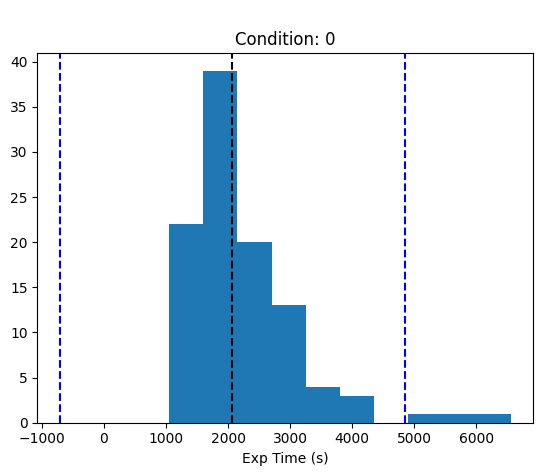

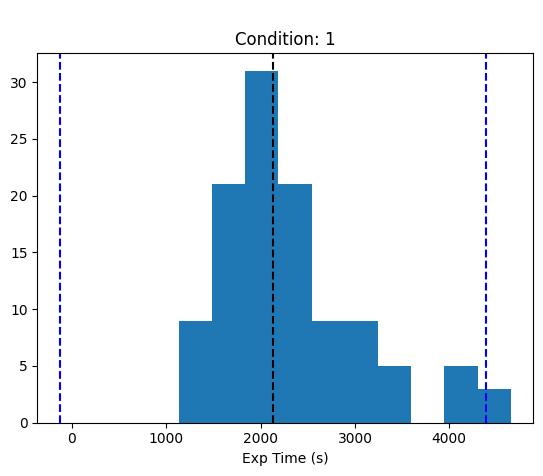

In [34]:
# Time taken per condition

exceeded_parts = []

for condition in [0,1]:
    print("\nCondition: " +str(condition))
    condition_df = complete_data.loc[complete_data.condition == condition]
    clength = condition_df.expLength
    mean = clength.mean()
    sd = clength.std()
    med = clength.median()
    print("Mean: " + str(mean/60))
    print("Std: " + str(sd/60))
    print("Median: " + str(med/60))
    
    time_exceed_df = condition_df.loc[(condition_df.expLength > med + 3*sd) | (condition_df.expLength < med - 3*sd)]
    exceeded_parts += list(time_exceed_df.workerId)
    
    plt.figure()
    plt.hist(clength)
    plt.axvline(med, linestyle='--', color='black')
    plt.axvline(med + 3*sd, linestyle='--', color='blue')
    plt.axvline(med - 3*sd, linestyle='--', color='blue')
    plt.title("\nCondition: " +str(condition))
    plt.xlabel("Exp Time (s)")
    
plt.show()


In [35]:
# Exclude based on time only with full dataset, not with partial dataset
exclude_time = False

In [36]:
# Excluding participants based on time

if exclude_time:
    within_time_parts = complete_data.loc[~complete_data.workerId.isin(exceeded_parts)]
else:
    within_time_parts = complete_data
print(len(within_time_parts.loc[within_time_parts.condition == 0]))
print(len(within_time_parts.loc[within_time_parts.condition == 1]))
print("\n")
for part in exceeded_parts:
    print(part, list(complete_data.loc[complete_data.workerId == part]["condition"])[0])

104
113


60ed6ef739959cc28d143526 0
64835cdc41f91285bcbd2de1 0
60f7fe3289f34e538e2d436e 0
615c649d57863892eb7f8cf2 1
616657d3063dd77f0ad2b866 1
613c7f972e67021c3fe9fd40 1


In [37]:
if exclude_time:
    for p in exceeded_parts:
        excluded_parts.append({
            "workerId": p,
            "reason": "exceededTime"
        })

In [38]:
# Excluding participants based on effort
ineffortful_parts = within_time_parts.loc[within_time_parts.effort > 1]
ineffortful_parts[["workerId", "condition", "effort"]]


,workerId,condition,effort
80,615349801b7897c0c37bd359,0,3
127,615dd36156bf443246c0b660,0,2
273,5d55a0f63af827001981b8d6,1,3


In [39]:
effortful_parts = within_time_parts.loc[~within_time_parts.workerId.isin(list(ineffortful_parts.workerId))]
print(len(effortful_parts.loc[effortful_parts.condition == 0]))
print(len(effortful_parts.loc[effortful_parts.condition == 1]))


102
112


In [40]:
for p in ineffortful_parts.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "noeffort"
    })

In [41]:
# Excluding participants who already have done the task
for idx, (workerId, ans) in effortful_parts[["workerId","alreadyParticipated"]].iterrows():
    if "no" not in ans.lower() and "never" not in ans.lower():
        print(workerId, ans)

5dc3ebd9d0b86f2c8dc18c30 I am pretty sure I haven't played this game before.
6166a03f5063db088c458b73 It was my first time participating in this HIT 
606c6e9f7e86c0264ab3d7d8 Yes, but this one was different. The inspected values only remained for a few seconds.
5c28d36b6fbaed00010847a8 I haven't participated in a HIT game before. 
6112aa865f237cf99d0b0094 this was the first one
63174af7d57182f9bf90c094 yes, I did
605de3af48d7a575adb95b09 yes
60c142fad3c33f80288c9aa2 Nah hadn't participated in a Web of Cash HIT before. But very interested on doing similar HITs.
614e446e77a6b2d836cb3817 I CANT REMEMBER
6152d2c25633d4867ff66ac7 yes
60f7fe3289f34e538e2d436e N/A
5eb12f8510e0ce205e7b25c7 N/A
61054d9e01155b7e94f9652f this was my first time doing a web of cash HIT, or any other HIT for that matter
631610af8e747093cd90e00d I don't believe I've done this before.
61088f5351df7edad3fa8c5f it was my first 
5fa0091ec747500252d2891f This was my first time
5e8e38da572c650e2ede51c9 NA
61267b828ead584bc

In [42]:
# Already participated have to be filtered manually

already_participated_ids = ["60ee22675c5d675ac2999a0a", "615eb4359e91a19283b519cf", "60eccd4d9b4a0c1f4ab919a4",
                           "614324d428b2dd34dce610a5", "6136266c04528ef90b95faa5", "60faab6f9d9a835ba3b8327f"]

already_participated = effortful_parts.loc[effortful_parts.workerId.isin(already_participated_ids)]
already_participated[["workerId", "condition"]]

,workerId,condition


In [43]:
for p in already_participated.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "alreadyparticipated"
    })

In [44]:
new_parts = effortful_parts.loc[~effortful_parts.workerId.isin(already_participated_ids)]
print(len(new_parts.loc[new_parts.condition == 0]))
print(len(new_parts.loc[new_parts.condition == 1]))

102
112


In [45]:
# Participant data that is complete and that also has valid click strategies 

valid_click_strat_data = new_parts.loc[new_parts.clickStratsValid]
print(len(valid_click_strat_data.loc[valid_click_strat_data.condition == 0]))
print(len(valid_click_strat_data.loc[valid_click_strat_data.condition == 1]))
#print(len(complete_data.loc[complete_data.condition == 2]))
valid_click_strat_data

102
105


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,6139d8c791c9b4805690b33e,2023-08-03 13:52:38.740180,2023-08-03 14:31:03.713222,2023-08-03 13:52:56.912862,3,chrome,windows,en-US,2304.0,2285.706,...,very difficult,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Ne...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,-110.0,1882.504,-403.202,18461.450,0.0
1,60f724fd8ec131e82a00b129,2023-08-03 14:04:55.055212,2023-08-03 14:42:06.262855,2023-08-03 14:05:59.912165,3,chrome,windows,en-US,2231.0,2164.976,...,Very difficult because I was not able to pick ...,{},0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,-387.4,1736.868,-428.108,34270.925,0.0
2,5db050bee16e28001752bc92,2023-08-04 10:29:50.900109,2023-08-04 10:54:11.738245,NaT,3,chrome,windows,en-US,1460.0,1446.883,...,the penalty of choosing wrong path was huge,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-198.6,1006.268,-440.615,18855.975,0.0
5,64803fe717b0a137be421ae1,2023-08-03 13:58:59.752854,2023-08-03 14:26:56.504620,2023-08-03 13:59:19.052220,3,chrome,windows,en-ZA,1676.0,1655.841,...,Each round seemed to be different in pattern f...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,95.6,1199.156,-456.685,17257.050,0.0
6,613758e7a80409ba7f5affb6,2023-08-04 14:37:56.879600,2023-08-04 15:49:31.228143,2023-08-04 14:39:25.918533,3,chrome,windows,en-US,4294.0,4202.550,...,not knowing which node has much value,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1615.2,3084.335,-1118.215,61369.025,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,60dcb953677e49a70004a4da,2023-08-04 09:45:20.609873,2023-08-04 10:20:12.422599,2023-08-04 09:45:30.440566,3,chrome,windows,en-US,2091.0,2080.129,...,It was so tricky without the node because i do...,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1155.8,1604.206,-475.923,25133.225,0.0
270,615af3dba5d55e14ea6bdeda,2023-08-04 09:43:16.349377,2023-08-04 10:13:25.126772,2023-08-04 09:43:36.781516,3,chrome,windows,en-ZA,1808.0,1708.549,...,Very difficult. The values are random so there...,"{'Q0': 'Agree', 'Q1': 'Disagree', 'Q2': 'Agree...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-119.0,1168.363,-540.186,21432.500,0.0
271,6173a66fe893f70a2506e6f3,2023-08-03 13:56:39.844314,2023-08-03 14:26:23.505742,2023-08-03 13:56:53.257462,3,chrome,windows,en-US,1783.0,1768.404,...,"Moderately difficult, It took a couple of roun...",{},0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,1493.8,1171.804,-596.600,23412.625,0.0
272,615b3fcbe06552b583481a65,2023-08-03 13:54:30.112558,2023-08-03 14:35:11.523626,2023-08-03 14:04:58.916054,3,chrome,windows,en-US,2441.0,1811.744,...,Pretty difficult because the rounds keep chang...,{},0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,2479.4,1183.328,-628.416,24059.800,0.0


In [46]:
# Excluding participants

invalid_click_strat_data = new_parts.loc[~new_parts.clickStratsValid]
for p in invalid_click_strat_data.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "invalidClickStrats"
    })

In [47]:
# Final score per condition

for condition in [0,1,2]:
    print("\nCondition: " +str(condition))
    clength = new_parts.loc[new_parts.condition == condition].finalScore
    print("Mean: " + str(clength.mean()))
    print("Std: " + str(clength.std()))
    print("Median: " + str(clength.median()))


Condition: 0
Mean: 1186.1352941176472
Std: 917.7563680079912
Median: 1325.9

Condition: 1
Mean: 1036.380357142857
Std: 836.115506330314
Median: 1245.6

Condition: 2
Mean: nan
Std: nan
Median: nan


In [49]:
# Updating all files of participants whose data should be excluded

for ep in excluded_parts:
    w = ep["workerId"]
    # Get the file name 
    file = [fn for fn in os.listdir(datafolder) if w in fn][0]
    fpath = datafolder + file
    # Read the json
    with open(fpath, 'r') as f:
        participant = json.load(f)
    # Add the fields
    participant["excludeReason"] = ep["reason"]
    # Rewrite the file
    with open(fpath, 'w') as fw:
        json.dump(participant, fw)
    print(f"Wrote to {file}: {ep['reason']}")
    
    

Wrote to full_r_3_5b587d897846fa0001fc11c6.json: dropout
Wrote to full_r_2_614dd477b69221b863e025af.json: dropout
Wrote to full_r_2_5e3421311ddb123e1de9e6ad.json: dropout
Wrote to full_r_1_615ec038e5541708b1925af2.json: dropout
Wrote to full_r_2_60cc72425533320442c05f8c.json: dropout
Wrote to full_r_1_6176b584db27cdcecc3896c8.json: dropout
Wrote to full_r_1_613110abdaced6861846c409.json: dropout
Wrote to full_r_4_5c8cfc3772503f0001e9c965.json: dropout
Wrote to full_r_5_60daf06339dsacaccef1a00932.json: dropout
Wrote to full_r_3_5fad0a601ab00734f83bf339.json: dropout
Wrote to full_r_2_6130815ed54ea2aeb63c7eea.json: dropout
Wrote to full_r_3_60cce1dff5946c42b4402084.json: dropout
Wrote to full_r_4_6164091188e0c0d34665c821.json: dropout
Wrote to full_r_2_613b789d93a4e9a50e6e2c0b.json: dropout
Wrote to full_r_2_617678a3559642b86549849d.json: dropout
Wrote to full_r_5_60471ddd0b6ed718cb843760.json: dropout
Wrote to full_r_3_616033a44ba802b7e18daaa9.json: dropout
Wrote to full_r_3_6050cb50a96

In [58]:
sorted(list(new_parts.workerId))

['5512eee1fdf99b7e1fb1be40',
 '567f59e0d18c640011e7ac0b',
 '57308d1530a5560010ecbc1a',
 '57618e8a25224a0006d3756e',
 '5873b2d22bd3c90001859b76',
 '58f669cefb4d7500014af69b',
 '594abd98215cbd000146debc',
 '596e1edd39e9d00001b7bb98',
 '59aae1188cef7d00011f8884',
 '59b7cbab110131000146620b',
 '5a1323835d06850001b00673',
 '5aa18536dbdb470001ef2cf1',
 '5aa6fcaa1ade740001b9730b',
 '5aafd9eff69e940001d88bf4',
 '5b258c9ba7cee100011d8aad',
 '5b2a72f7c293b90001732b89',
 '5b4e2703995d4e0001093117',
 '5b9d57e5737d030001ad2cbf',
 '5bc35acbe5fc0200012ab7c1',
 '5bfaf20ecad1240001e8de8c',
 '5bfece626e6cd80001beb6c0',
 '5c1da6adaaf13200014292cc',
 '5c37ac66bc6444000133b38e',
 '5c43724ab00b3300018f49bf',
 '5c49d339b43d260001e4dbcb',
 '5c50efd2cc71f4000125ce0d',
 '5c559af233ed050001dffa66',
 '5c58a9908f34eb0001574867',
 '5c5da3b159ec1d0001fe5606',
 '5c735f3106f23500016d6c97',
 '5c7ceda01d2afc0001f4ad1d',
 '5c92f797803bff0017fef8dd',
 '5c94148a8c4d820001d361d9',
 '5cbb3393114fa50001ac523f',
 '5cc53cf32916

# Creating CSV for MCL Toolbox

Converting participant data into a CSV format that is appropriate for reading by mcl_toolbox models

In [46]:
s = "pid,trial_index,action_time,actions,block,path,queries,reward,rt,condition,bonus,score,simulation_mode,state_rewards,time_elapsed,trialTime,trial_type"

for h in s.split(","):
    print("\"{}\",".format(h))

"pid",
"trial_index",
"action_time",
"actions",
"block",
"path",
"queries",
"reward",
"rt",
"condition",
"bonus",
"score",
"simulation_mode",
"state_rewards",
"time_elapsed",
"trialTime",
"trial_type",


In [48]:
header_row = [
    "pid",
    "trial_index",
    "action_time",
    "actions",
    "block",
    "path",
    "queries",
    "reward",
    "rt",
    "condition",
    "bonus",
    "score",
    "simulation_mode",
    "state_rewards",
    "time_elapsed",
    "trialTime",
    "trial_type",
    "reward_withheld"
]


In [53]:
scarce_complete = new_parts[new_parts.condition == 1]
control_complete = new_parts[new_parts.condition == 0]


control_csv_rows = [header_row]
scarce_csv_rows = [header_row]

# Create a CSV table with all the trials as rows
for workerId in new_parts.workerId:
    # Read data as was present in PostGRES output
    # Part_data object created at very beginning of this notebook
    participant = part_data[workerId]
    trial_count = 1
    click_cost = participant["condition"] * 0.25 + (1 - participant["condition"])
    for idx, data_point in enumerate(participant["data"]):
        trialdata = data_point["trialdata"]
        if trialdata["trial_type"] == "mouselab-mdp" and trialdata["trial_id"].startswith("mdp_"):
            if trial_count > 40: 
                print(workerId)
                continue
            num_clicks = len(trialdata["queries"]["click"]["state"]["target"])
            new_row = [
                workerId,
                trial_count,
                trialdata["actionTimes"],
                trialdata["actions"],
                "begin" if trial_count <= 10 else "test",
                trialdata["path"],
                trialdata["queries"],
                trialdata["rewards"],
                trialdata["rt"],
                participant["condition"],
                0,
                trialdata["score"],
                [None] * 5,
                trialdata["stateRewards"],
                trialdata["time_elapsed"],
                trialdata["trialTime"],
                trialdata["trial_type"],
                trialdata["withholdReward"]
            ]
            trial_count += 1
            # print(click_cost, num_clicks, trialdata["score"], new_row[11], new_row[-1])
            if participant["condition"] == 0:
                control_csv_rows.append(new_row)
            else:
                scarce_csv_rows.append(new_row)
    
    

In [54]:
# Write to CSV file

with open('../results/mcl_toolbox/mouselab-mdp-final-misaligned.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in scarce_csv_rows:
        writer.writerow(row)


In [55]:
# Write to CSV file

with open('../results/mcl_toolbox/mouselab-mdp-final-control.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in control_csv_rows:
        writer.writerow(row)


In [8]:
# Creating CSV for optimal strategy to infer sequences

optimalpicklename = "../results/1.0_clicks_high_increasing_.pickle"

with open(optimalpicklename, 'rb') as file:
    optimal_clicks = pickle.load(file)
    
opt_csv_rows = [header_row]

trial_count = 1

for trial in optimal_clicks["optimal"]:
    trial_rewards = [trial["stateRewards"][int(c)] for c in trial["clicks"][:-1]]
    new_row = [
        "dynamic_program",
        trial_count,
        [],
        [],
        "begin" if trial_count <= 10 else "test",
        [],
        { 
            "click" : { 
                "state" : {
                    "target" : trial["clicks"][:-1],
                    "times" : list(range(len(trial["clicks"][:-1])))
                }
            }
        },
        trial_rewards,
        [3] * len(trial["clicks"][:-1]),
        0,
        0,
        0,
        [None] * 3,
        trial["stateRewards"],
        None,
        None,
        "mouselab-mdp"

    ]
    trial_count += 1
    opt_csv_rows.append(new_row)
    if trial_count == 31: 
        break

In [9]:
# Write to CSV file

with open('../results/mouselab-mdp-final-dp.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in opt_csv_rows:
        writer.writerow(row)


## Feedback and Demographics

In [59]:
len(complete_data)

329

In [60]:
# Feedback comments

for part in part_stats_dicts:
    printed = False
    if len(part["feedback"]) > 0:
        print("Feedback: " + part["feedback"])
        printed = True
    if len(part["alreadyParticipated"]) > 0:
        print("Already participated: " + part["alreadyParticipated"])
        printed = True
    if len(part["comments"]) > 0:
        print("Comments: " + part["comments"])
        printed = True
    if printed:
        print("\n")

Feedback: No.
Already participated: No, have never participated before.


Feedback: No, all seemed straightforward
Already participated: No, I haven't.
Comments: Was fun, thanks :)


Already participated: 26
Comments: male


Feedback: yes, it was complicated
Already participated: 26
Comments: male


Feedback: No, the experiment was clear.
Already participated: No, I hadn't.
Comments: None.


Feedback: I seemed to have more time to use the node inspector that I initially thought.  I thought I only had 3 seconds in total to check as many nodes as possible. but I soon realised how this worked.
Already participated: No
Comments: I enjoyed that, Thank you.


Feedback: Not at all.
Already participated: No.


Feedback: Not at all
Already participated: No I never did a HIT Game before.


Feedback: No
Already participated: No


Feedback: Nothing was difficult to understand, the instructions were clear and easy.
Already participated: I have never participated in this game before.


Feedback: It 

In [61]:
# Demographics:

which_df = new_parts

conditions = {
    0: "Control",
    1: "Misaligned"
}

ages = {
    "all" : which_df["age"].astype("int")
}

num_male = {
    
}
num_female = {
    
}
num_other = {
    
}
gender_unique, gender_counts = np.unique(which_df.gender, return_counts=True)
genders = np.asarray((gender_unique, gender_counts)).T
num_male["all"] = genders[np.where(genders[:,0] == "male")[0][0], 1]
num_female["all"] = genders[np.where(genders[:,0] == "female")[0][0], 1]

try:
    num_other["all"] = genders[np.where(genders[:,0] == "other")[0][0], 1]
except:
    num_other["all"] = 0

for cond in conditions.keys():
    sub_df = which_df.loc[which_df.condition == cond]
    ages[cond] = sub_df["age"].astype("int")
    gender_unique, gender_counts = np.unique(sub_df.gender, return_counts=True)
    genders = np.asarray((gender_unique, gender_counts)).T
    num_male[cond] = genders[np.where(genders[:,0] == "male")[0][0], 1]
    num_female[cond] = genders[np.where(genders[:,0] == "female")[0][0], 1]
    try:
        num_other[cond] = genders[np.where(genders[:,0] == "other")[0][0], 1]
    except:
        num_other[cond] = 0


efforts = which_df["effort"].astype("int")
colorblind_unique, colorblind_counts = np.unique(which_df.colorblind, return_counts=True)
colorblinds = np.asarray((colorblind_unique, colorblind_counts)).T

print("Age stats:")
print("\tOverall:")
print("\t\tMean: {0:0.3f}".format(ages["all"].mean()))
print("\t\tSD: {0:0.3f}".format(ages["all"].std()))
print("\t\tMedian: {0:0.3f}".format(ages["all"].median()))
print("\t\tMax: {0:0.3f}".format(ages["all"].max()))
print("\t\tMin: {0:0.3f}".format(ages["all"].min()))
for cond, condname in conditions.items():
    sub_df = which_df.loc[which_df.condition == cond]
    print(f"\t{condname}:")
    print("\t\tMean: {0:0.3f}".format(ages[cond].mean()))
    print("\t\tSD: {0:0.3f}".format(ages[cond].std()))
    print("\t\tMedian: {0:0.3f}".format(ages[cond].median()))
    print("\t\tMax: {0:0.3f}".format(ages[cond].max()))
    print("\t\tMin: {0:0.3f}".format(ages[cond].min()))

print("Gender stats:")
print("\tOverall:")
print("\t\tMale: {0} ({1:0.2f}%)".format(num_male["all"], (100 * num_male["all"] / len(which_df))))
print("\t\tFemale: {0} ({1:0.2f}%)".format(num_female["all"], (100 * num_female["all"] / len(which_df))))
print("\t\tOther: {0} ({1:0.2f}%)".format(num_other["all"], (100 * num_other["all"] / len(which_df))))
for cond, condname in conditions.items():
    sub_df = which_df.loc[which_df.condition == cond]
    print(f"\t{condname}:")
    print("\t\tMale: {0} ({1:0.2f}%)".format(num_male[cond], (100 * num_male[cond] / len(sub_df))))
    print("\t\tFemale: {0} ({1:0.2f}%)".format(num_female[cond], (100 * num_female[cond] / len(sub_df))))
    print("\t\tOther: {0} ({1:0.2f}%)".format(num_other[cond], (100 * num_other[cond] / len(sub_df))))


Age stats:
	Overall:
		Mean: 31.971
		SD: 11.621
		Median: 29.000
		Max: 67.000
		Min: -31.000
	Control:
		Mean: 32.401
		SD: 10.892
		Median: 29.000
		Max: 67.000
		Min: 19.000
	Misaligned:
		Mean: 31.560
		SD: 12.298
		Median: 29.000
		Max: 67.000
		Min: -31.000
Gender stats:
	Overall:
		Male: 131 (42.12%)
		Female: 177 (56.91%)
		Other: 3 (0.96%)
	Control:
		Male: 58 (38.16%)
		Female: 93 (61.18%)
		Other: 1 (0.66%)
	Misaligned:
		Male: 73 (45.91%)
		Female: 84 (52.83%)
		Other: 2 (1.26%)


In [62]:
# Effort:

which_df = new_parts

conditions = {
    0: "Control",
    1: "Misaligned"
}


for cond in conditions.keys():
    sub_df = which_df.loc[which_df.condition == cond]
    print("\n" + conditions[cond])
    print(sub_df["effort"].value_counts())




Control
effort
0    137
1     15
Name: count, dtype: int64

Misaligned
effort
0    135
1     24
Name: count, dtype: int64


In [63]:
# Comments on difficulty and strategy - all conditions

for cond, condname in conditions.items():
    print(f"\n------ {condname} ------\n")
    for part in part_stats_dicts:
        if part['condition'] != cond: continue
        printed = False
        if len(part["whatStrategy"]) > 0:
            print("Strategy Used: " + part["whatStrategy"])
            printed = True
        if len(part["strategyImprove"]) > 0:
            print("How strategy was improved: " + part["strategyImprove"])
            printed = True
        if len(part["difficult"]) > 0:
            print("Difficulty: " + part["difficult"])
            printed = True
        if printed:
            print("\n")


------ Control ------

Strategy Used: I used the nodes inspector on the nodes which I thought would be my end target to see if I was satisfied with the amount, if it was a decent credit I would head to that node.  I tried to see the value of few a nodes as possible to save the expense
How strategy was improved: I'm not sure I did, if at all only by using the node inspector less.
Difficulty: I was happy with my performance after I concentrated on reaching an end node with a decent credit to aim for.  So long as I was in credit that was OK.  I did get frustrated a couple of times and headed off with no particular target after using the node inspector and not seeing a credit amount, but at least I had an idea of not where to head.


Strategy Used: I choose the path that give me positive point the most.
How strategy was improved: Yes, The path that give me negatives most of the time I did not use very often
Difficulty: No much.


Strategy Used: To view the last nodes and see which one has

In [64]:
# Stats on self-report of clicks at first level - all conditions

questions = {
    "Q0": "In most rounds, I clicked the nodes at the first level.",
    "Q1": "When ..., it was ONLY to receive the immediate $0.25 reward.",
    "Q2": "When ..., it was NOT ONLY to receive the immediate $0.25 reward.",
    "Q3": "When ..., I did it to see the numbers that were present at those nodes.",
    "Q4": "When ..., I did for another reason than to see the numbers that were present at those nodes.",
    "Q5": "When ..., I paid attention to the numbers that were present at those nodes.",
    "Q6": "When ..., I did NOT pay attention to the numbers that were present at those nodes."
}

longest_q_len = max([len(a) for a in questions.values()])

df_dicts = []

# Pad answers with spaces
for q in questions.keys():
    qtext = questions[q]
    questions[q] += "".join([" "] * (longest_q_len - len(qtext)))

answers = ["Strongly disagree", "Disagree", "Neither disagree nor agree", "Agree", "Strongly agree"]
answer_abbr_map = {a: ''.join([w[0] for w in a.split(" ")]).upper() for a in answers}

for cond, condname in conditions.items():
    print(f"\n------ {condname} ------\n")
    for part in part_stats_dicts:
        if part['condition'] != cond: continue
        if part['workerId'] not in list(complete_data.workerId): continue
        printed = False
        prop_L1clicks = sum([bool(c) for c in part["clicksL1"]])/len(part["clicksL1"])
        if prop_L1clicks < 0.1: continue
        print("\n", part["workerId"], part["clickStratsValid"], prop_L1clicks)
        for qnum, ans in part["firstLevelAns"].items():
            print(questions[qnum], "\t", answer_abbr_map[ans])#answers.index(ans))
        dict_ = {k: answers.index(v) for (k,v) in part["firstLevelAns"].items()}
        dict_["cL1_mean"] = np.mean(part["clicksL1"])
        df_dicts.append(dict_)
        printed = True
        if printed:
            print("\n")
            
strategy_ans_df = pd.DataFrame.from_dict(df_dicts).dropna()


------ Control ------


 6137753896c9b6b5813a2432 True 0.1



 616ed458582d2c3b50149493 True 0.125



 60f6b8f8e574e14634ead43e True 0.1



 6365805113952480bdeed7b7 True 0.45



 615fdd9674ec001e9d325841 True 0.15



 6113d1d02fbd58ed15b3c8e0 True 0.775



 6472025f5e1c922497375ce2 True 0.1



 5d960ffd35a770001a9a0592 True 0.4



 5f64647e17ef411eb0c20359 True 0.95



 60f556ba228c7c08807bb245 True 0.1



 59aae1188cef7d00011f8884 True 0.1



 615a0de3f6c9090c532c3e89 True 0.425



 615b4312203a83322f1b38dc True 0.825



 5e7fa0e918b10804bb87eb63 True 0.95



 647df23a62de26114fdcb29c True 0.2



 5fc00a11268eb941e7d8b066 True 0.125



 5aa18536dbdb470001ef2cf1 True 0.1



 5d341b57a48ae7000114152a True 0.3



 5f9eab308e503705011ad793 True 0.975



 5fe24f4dcb7697decd41db77 True 0.15



 63037fccaa39a2ba4ed84750 True 0.1



 60e0fc6ba2a0b43c2e64fefb True 0.45



 5f1bfe98441e2743f34fa16a True 0.85



 615f4ddc420b1b75f246a4ec True 0.1



 6153554048e1825ac1946e84 True 0.425



 5f0

In most rounds, I clicked the nodes at the first level.                                      	 SD
When ..., it was ONLY to receive the immediate $0.25 reward.                                 	 D
When ..., it was NOT ONLY to receive the immediate $0.25 reward.                             	 NDNA
When ..., I did it to see the numbers that were present at those nodes.                      	 D
When ..., I did for another reason than to see the numbers that were present at those nodes. 	 A
When ..., I paid attention to the numbers that were present at those nodes.                  	 A
When ..., I did NOT pay attention to the numbers that were present at those nodes.           	 D



 60e0ec03d5f63fb47a3e29b7 False 0.1
In most rounds, I clicked the nodes at the first level.                                      	 NDNA
When ..., it was ONLY to receive the immediate $0.25 reward.                                 	 SD
When ..., it was NOT ONLY to receive the immediate $0.25 reward.                

0.5524836588213468


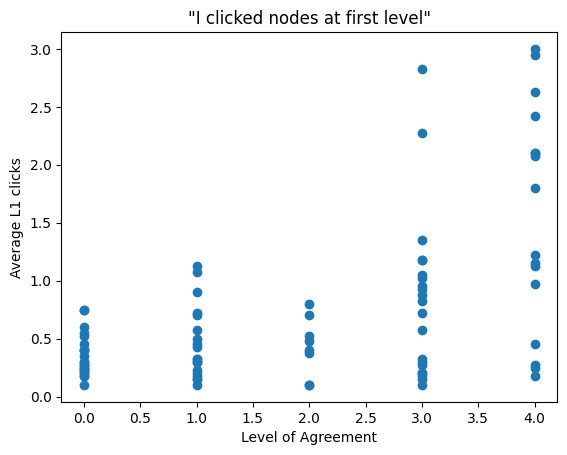

In [65]:
print(strategy_ans_df["Q0"].corr(strategy_ans_df["cL1_mean"]))
plt.scatter(strategy_ans_df["Q0"], strategy_ans_df["cL1_mean"])
plt.title("\"I clicked nodes at first level\"")
plt.xlabel("Level of Agreement")
plt.ylabel("Average L1 clicks")
plt.show()

In [113]:
strategy_ans_df["Q4"].value_counts().sort_index()

Q4
0.0    5
1.0    4
2.0    3
4.0    2
Name: count, dtype: int64

In [156]:
strategy_ans_df.where(strategy_ans_df > 2, 100)

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,3.0,100.0,100.0,100.0,3.0,100.00
1,3.0,100.0,3.0,100.0,3.0,100.00
2,100.0,100.0,3.0,100.0,100.0,100.00
3,4.0,100.0,4.0,4.0,100.0,100.00
4,3.0,100.0,100.0,3.0,100.0,100.00
5,3.0,100.0,100.0,3.0,100.0,100.00
6,100.0,100.0,100.0,100.0,100.0,100.00
8,4.0,100.0,3.0,100.0,3.0,100.00
9,100.0,3.0,100.0,4.0,4.0,100.00
10,100.0,100.0,100.0,3.0,100.0,100.00


In [165]:
agreement_df == 2

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,True,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
5,False,False,False,False,True,False
6,False,False,False,False,False,False
8,False,True,False,False,False,False
9,False,False,False,False,False,False
10,False,False,False,False,False,False


In [172]:
agreement_df = strategy_ans_df.copy()
agreement_df = agreement_df.where(agreement_df >= 2, -1)
agreement_df = agreement_df.where(agreement_df <= 2, 1)
agreement_df = agreement_df.where(agreement_df != 2, 0)
agreement_df["cL1_mean"] = strategy_ans_df["cL1_mean"]

agreement_df

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,1.0,-1.0,-1.0,-1.0,1.0,0.12
1,1.0,-1.0,1.0,-1.0,1.0,0.36
2,-1.0,-1.0,1.0,-1.0,0.0,0.04
3,1.0,-1.0,1.0,1.0,-1.0,1.96
4,1.0,-1.0,-1.0,1.0,-1.0,0.00
5,1.0,-1.0,-1.0,1.0,0.0,0.60
6,-1.0,-1.0,-1.0,-1.0,-1.0,0.00
8,1.0,0.0,1.0,-1.0,1.0,0.00
9,-1.0,1.0,-1.0,1.0,1.0,0.28
10,-1.0,-1.0,-1.0,1.0,-1.0,0.00


In [176]:
(agreement_df["Q1"] + agreement_df["Q2"]).value_counts()

 0.0    13
-2.0    10
-1.0     4
 1.0     2
Name: count, dtype: int64

In [85]:
correct_answers = {
    "Q0": "$-2 to $2",
    "Q1": "$-16 to $16",
    "Q2": "$-88 to $88"
}

num_correct = {}
questions_correct = {}
bonus = {}

for cond in conditions.keys():
    num_correct[cond] = []
    questions_correct[cond] = {
        "Q0": 0,
        "Q1": 0,
        "Q2": 0
    }
    bonus[cond] = []
    sub_df = complete_data.loc[complete_data.condition == cond]
    for idx, row in sub_df.iterrows():
        part = [p for p in part_stats_dicts if p["workerId"] == row["workerId"]][0]
        part_answers = part['final_quiz_responses']
        part_correct_answers = sum([part_answers[key] == correct_answers[key] for key in correct_answers.keys()])
        num_correct[cond].append(part_correct_answers)
        for q in correct_answers.keys():
            questions_correct[cond][q] += int(part_answers[q] == correct_answers[q])
        part_bonus = full_bonus_eligible.loc[full_bonus_eligible.workerId == row["workerId"]].bonus.values[0]
        bonus[cond].append(part_bonus)



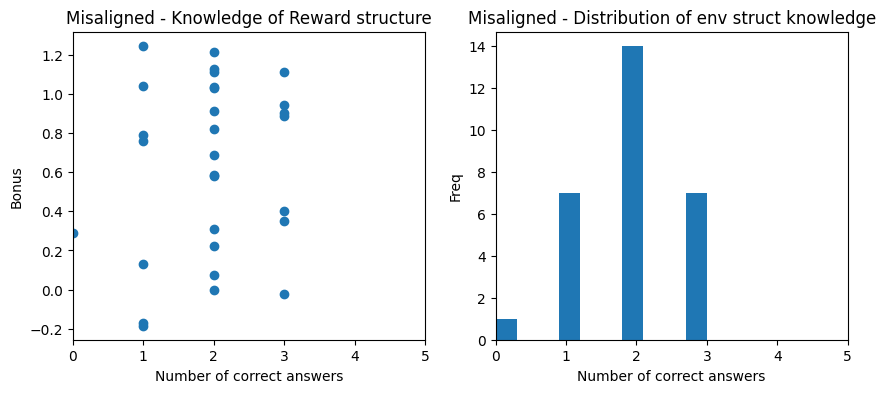

In [86]:


for idx, (cond, condname) in enumerate(conditions.items()):
    plt.figure(figsize=(5 * 2,4 * len(conditions)))
    plt.subplot(1,2,1)
    plt.scatter(num_correct[cond], bonus[cond])
    plt.xlabel("Number of correct answers")
    plt.ylabel("Bonus")
    plt.title(f"{condname} - Knowledge of Reward structure")
    plt.xlim([0,5])
    plt.subplot(1,2,2)
    plt.hist(num_correct[cond])
    plt.xlabel("Number of correct answers")
    plt.ylabel("Freq")
    plt.xlim([0,5])
    plt.title(f"{condname} - Distribution of env struct knowledge")

plt.show()

In [87]:
questions_correct

{0: {'Q0': 20, 'Q1': 13, 'Q2': 23}}